In [1]:
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.utils import check_random_state
import torch

## Toy data make

In [2]:
def make_moons(n_samples=100, xy_ratio=1.0, x_gap=0.0, y_gap=0.0, noise=None, seed=None):
    """
    code borrowed from :: https://github.com/lovit/synthetic_dataset
    """

    n_samples_out = n_samples // 2
    n_samples_in = n_samples - n_samples_out

    generator = check_random_state(seed)

    outer_circ_x = np.cos(np.linspace(0, np.pi, n_samples_out)) - x_gap
    outer_circ_y = xy_ratio * np.sin(np.linspace(0, np.pi, n_samples_out)) + y_gap
    inner_circ_x = 1 - np.cos(np.linspace(0, np.pi, n_samples_in)) + x_gap
    inner_circ_y = xy_ratio * (1 - np.sin(np.linspace(0, np.pi, n_samples_in)) - (.5 + y_gap))

    X = np.vstack((np.append(outer_circ_x, inner_circ_x),np.append(outer_circ_y, inner_circ_y))).T
    labels = np.hstack([np.zeros(n_samples_out, dtype=np.intp),np.ones(n_samples_in, dtype=np.intp)])

    if noise is not None:
        noise = generator.normal(scale=noise, size=X.shape)
        noise[:,1] = noise[:,1] * xy_ratio
        X += noise

    return X, labels

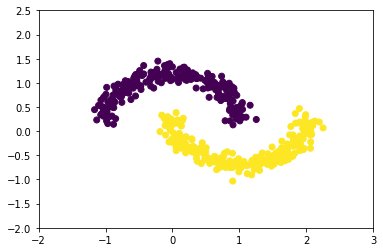

In [3]:
x, y = make_moons(n_samples=500, 
xy_ratio=1.0, x_gap=0, y_gap=0.2, noise=0.1)
plt.axis([-2, 3, -2, 2.5]) 
plt.scatter(x[:,0], x[:,1], c=y)

In [4]:
print(" x shape :: ", x.shape)
print(" y shape :: ", y.shape)

 x shape ::  (500, 2)
 y shape ::  (500,)


In [5]:
xx = np.arange(-2, 3, 0.05)
yy = np.arange(-2, 3, 0.05)

Xx,Yy = np.mgrid[-2:3:0.05, -2:3:0.05]
xy_np = np.vstack((Xx.flatten(), Yy.flatten())).T
xy = torch.tensor(xy_np)

## GMM pytorch with autograd

In [26]:
import torch.nn as nn
import torch.distributions as D
import torch.nn.functional as F

class GMM(nn.Module):
    def __init__(self, dim, k=5):
        super(GMM, self).__init__()
        self.k = k 
        self.dim = dim
        self.mu  = nn.Parameter(torch.randn(k, dim)/2.)
        self.cov = nn.Parameter(torch.ones(k, dim)*-3e-2)
        self.pi = nn.Parameter(torch.ones(k,)/self.k)
        
    def forward(self, x):
        # x [B x d]
        cat = D.Categorical(F.softmax(self.pi))
        comp = D.Independent(D.Normal(self.mu, self.cov.exp()), 1)
        mixture = D.MixtureSameFamily(cat, comp)
        
        log_liks = mixture.log_prob(x)
        return log_liks
    
    def sample(self, size=1000):
        with torch.no_grad():
            cat = D.Categorical(F.softmax(self.pi))
            comp = D.Independent(D.Normal(self.mu, self.cov.exp()), 1)
            mixture = D.MixtureSameFamily(cat, comp)
            sample = mixture.sample((size,))
        
        return sample

gmm = GMM(dim=2, k=5)
print(gmm(torch.tensor(x)).mean())

tensor(-2.7719, dtype=torch.float64, grad_fn=<MeanBackward0>)


<ipython-input-26-c5f1a2822d74>:16: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  cat = D.Categorical(F.softmax(self.pi))


<ipython-input-26-c5f1a2822d74>:16: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  cat = D.Categorical(F.softmax(self.pi))
<ipython-input-26-c5f1a2822d74>:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  cat = D.Categorical(F.softmax(self.pi))


train finish694368243927


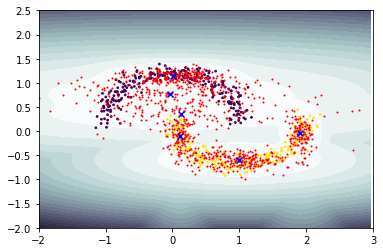

In [33]:
import torch.optim as optim
from celluloid import Camera

gmm_grad = GMM(k=6, dim=2,)
optimizer = optim.SGD(gmm_grad.parameters(), lr=1e-1, weight_decay=0)

fig = plt.figure()
ax = fig.subplots()
camera = Camera(fig)
EPOCH = 5000
print_every = EPOCH/40
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCH)

for ep in range(EPOCH):
    optimizer.zero_grad()
    
    log_liks = gmm_grad(torch.tensor(x))
    loss = log_liks.mean()* -1 
    
    print(str(ep)+" "+str(log_liks.mean().detach().numpy()), end='\r')
        
    loss.backward(retain_graph=True)
    optimizer.step()
    
    scheduler.step()
    
    if(ep %print_every ==0):
        samples= gmm_grad.sample()
        mu = gmm_grad.mu.detach().numpy()
        xx = np.arange(-2, 3, 0.05)
        yy = np.arange(-2, 3, 0.05)
        Xx,Yy = np.mgrid[-2:3:0.05, -2:3:0.05]
        xy_np = np.vstack((Xx.flatten(), Yy.flatten())).T
        xy = torch.tensor(xy_np)
        zz = gmm_grad(xy).detach().numpy().reshape(100,100).T
        
        ax.contourf(xx,yy,zz, 30, cmap=plt.cm.bone)
        ax.axis([-2, 3, -2, 2.5]) 
        ax.scatter(x[:,0], x[:,1], c=y, s=3)
        ax.scatter(samples[:,0], samples[:,1], c='r', s=1)
        ax.scatter(mu[:,0], mu[:,1], c='b', marker='x')

        camera.snap()

print("train finish")
animation = camera.animate(interval=50, blit=True)
animation.save('gmm_train.gif')


In [6]:
from IPython.display import Image
Image(url='./gmm_train.gif')  

In [182]:
!python3 --version

Python 3.9.2


In [183]:
torch.__version__

'1.8.0'